In [1]:
!pip -q install rdkit-pypi==2021.9.4|

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [3]:
import ast

import pandas as pd
import numpy as np
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

In [4]:
csv_path = keras.utils.get_file(
    "/content/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/content/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head()  

22606589/22606589 [==============================] - 0s 0us/step


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [5]:
smiles = df['smiles'].values
smiles_train = smiles[:10000]
smiles_val = smiles[10000:13000]
sol = df['logP'].values
sol_train = sol[:10000]
sol_val = sol[10000:13000]

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [7]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [8]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
max(smiles, key = len)

'C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@H]2O[C@@H]1O[C@H](C(=O)[O-])[C@@H](O)[C@H](O)[C@H]1O'

In [10]:
len("C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@H]2O[C@@H]1O[C@H](C(=O)[O-])[C@@H](O)[C@H](O)[C@H]1O")

109

In [11]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 109  # Only consider the first 200 words of each movie review


In [12]:
smiles_train = np.array(smiles_train)
smiles_val = np.array(smiles_val)

In [13]:
def get_data(smiles):
    

    
    chars = list(set(''.join(list(smiles))))
    int2char = dict(enumerate(chars,1))
    char2int = {char:ind for ind,char in int2char.items()}

    maxlen = max([len(x) for x in smiles])

    def tokenize(x):
        x = list(x)
        x = [char2int[c] for c in x] + [0]*(maxlen - len(x))
        return(x)

    X_train = np.array([tokenize(sm) for sm in smiles])

    smiles_len = (X_train > 0.0).sum(axis=1)
    max_features = len(chars) + 1 
    
    
    return X_train, max_features, maxlen, tokenize 

In [14]:
smiles = df['smiles'].values

In [15]:
smiles, max_feat, maxlen, tokenizer = get_data(smiles)

In [16]:
smiles

array([[17, 17, 27, ...,  0,  0,  0],
       [17, 32, 17, ...,  0,  0,  0],
       [19, 16, 17, ...,  0,  0,  0],
       ...,
       [17, 25,  7, ...,  0,  0,  0],
       [17, 25,  7, ...,  0,  0,  0],
       [ 5, 13, 17, ...,  0,  0,  0]])

In [17]:
smiles_train = smiles[:10000]
smiles_val = smiles[10000:13000]

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout, Bidirectional
from keras.layers import Embedding
import keras
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.preprocessing import sequence
from keras import backend as K
from keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
from rdkit import Chem
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr
import json
import os


import datetime

In [29]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

args = {'a1': 2, 'a3': 0, 'a4': 0, 'a5': 0, 'bs': 2, 'd1': 0.08607118576024131, 'd2': 0.4730059911045743, \
        'd3': 0.186637772607526, 'd4': 0.27122468227787655, 'd5': 0.15564916131523265, \
        'ed': 960.0, 'h1': 704.0, 'h3': 640.0, 'h4': 704.0, 'h5': 576.0, 'lr': 0, 'ls1': 256.0, 'nfc': 0, 'opt': 2}
act = {0:'relu', 1:'selu', 2:'sigmoid'}
inputs = Input(shape=(maxlen,))
x= Embedding(max_feat, 32, input_length=maxlen)(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x= Bidirectional(LSTM( int(args['ls1']), return_sequences=True))(x)
x= (Dropout( args['d1'] ) )(x)
x= (Bidirectional(LSTM( int(args['ls1']) )))(x)
x= (Dropout( args['d2'] ))(x)
x= (Dense(int( args['h1'] )))(x)
x= (Activation( act[args['a1']] ))(x)

x= (Dense( int(args['h3']) ))(x)
x= (Activation( act[args['a3']] ))(x)
x= (Dropout( args['d3'] ))(x)

outputs = Dense(1, activation="linear")(x)



model = Model(inputs=inputs, outputs=outputs)

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = CustomSchedule(128)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [47]:
model.compile(optimizer=optimizer, loss="mse", metrics=["mse"])

history = model.fit(smiles_train, sol_train, 
                    batch_size=64, epochs=15, 
                    validation_data=(smiles_val, sol_val)
                   )


Epoch 1/15
157/157 [==============================] - 18s 68ms/step - loss: 0.0795 - mse: 0.0795 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 2/15
157/157 [==============================] - 9s 58ms/step - loss: 0.0816 - mse: 0.0816 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 3/15
157/157 [==============================] - 9s 59ms/step - loss: 0.0823 - mse: 0.0823 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 4/15
157/157 [==============================] - 9s 59ms/step - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0688 - val_mse: 0.0688
Epoch 5/15
157/157 [==============================] - 9s 55ms/step - loss: 0.0700 - mse: 0.0700 - val_loss: 0.0593 - val_mse: 0.0593
Epoch 6/15
157/157 [==============================] - 9s 56ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 7/15
157/157 [==============================] - 9s 57ms/step - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0538 - val_mse: 0.0538
Epoch 8/15
157/157 [==============================] - 9s 57ms/step -

In [48]:
smiles_test = smiles[13000:16000]
sol_test = sol[13000:16000]

In [49]:
model.evaluate(smiles_test, sol_test)

94/94 [==============================] - 1s 15ms/step - loss: 0.0568 - mse: 0.0568


[0.056843195110559464, 0.056843195110559464]

In [50]:
preds = model.predict(smiles_test)

94/94 [==============================] - 3s 15ms/step


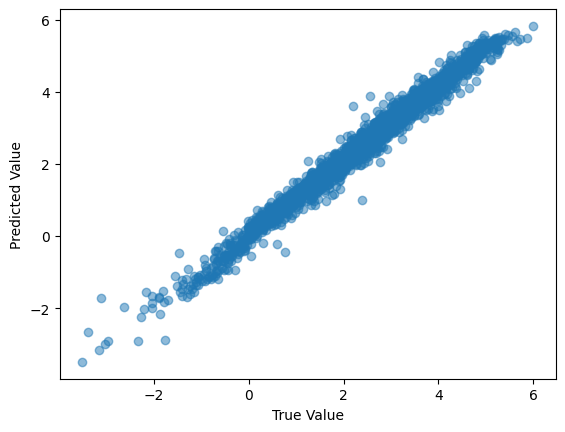

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility




plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.scatter(sol_test, preds, alpha=0.5)
plt.show()